# Calibration of epidemiological parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
from scipy.optimize import root_scalar
from math import gamma

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

In [2]:
def weibull_two_param(shape, scale):
    '''
    A two-parameter Weibull distribution, based on numpy ramdon's single 
    parameter distribution. We use this distribution in the simulation to draw
    random epidemiological parameters for agents from the given distribution
    See https://numpy.org/doc/stable/reference/random/generated/numpy.random.weibull.html
    '''
    return scale * np.random.weibull(shape)


def get_weibull_shape(k, mu, var):
    '''
    Calculates the shape parameter of a Weibull distribution, given its mean
    mu and its variance var
    '''
    return var / mu**2 - gamma(1 + 2/k) / gamma(1+1/k)**2 + 1



def get_weibull_scale(mu, k):
    '''
    Calculates the scale parameter of a Weibull distribution, given its mean
    mu and its shape parameter k
    '''
    return mu / gamma(1 + 1/k)


In [46]:
def get_true_epi_params(p):
    e, t, i, e_std, t_std, i_std = p
    curr_epi_params = {
        "exposure_duration":{"mean":e, "std":e_std},
        "time_until_symptoms":{"mean":t, "std":t_std},
        "infection_duration":{"mean":i, "std":i_std}
    }
    for param_name in curr_epi_params.keys():
        mu = curr_epi_params[param_name]["mean"]
        var = curr_epi_params[param_name]["std"]**2
        shape = root_scalar(get_weibull_shape, args=(mu, var),
                    method='toms748', bracket=[0.2, 500]).root
        scale = get_weibull_scale(mu, shape)
        curr_epi_params[param_name]["shape"] = shape
        curr_epi_params[param_name]["scale"] = scale
    
    exposure_duration = []
    time_until_symptoms = []
    infection_duration = []
    for i in range(1000):
        tmp_epi_params = {}
        while True:
            for param_name in curr_epi_params.keys():
                tmp_epi_params[param_name] = \
                    round(weibull_two_param(curr_epi_params[param_name]["shape"],
                                            curr_epi_params[param_name]["scale"]))

            if tmp_epi_params['exposure_duration'] >= 1 and \
               tmp_epi_params['time_until_symptoms'] >= \
               tmp_epi_params['exposure_duration'] and\
               tmp_epi_params['infection_duration'] >= \
               tmp_epi_params['time_until_symptoms']:
               break

        exposure_duration.append(tmp_epi_params['exposure_duration'])
        time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
        infection_duration.append(tmp_epi_params['infection_duration'])

    exposure_duration = np.asarray(exposure_duration)
    time_until_symptoms = np.asarray(time_until_symptoms)
    infection_duration = np.asarray(infection_duration)
    
    row = {
        'e_mean':curr_epi_params["exposure_duration"]["mean"],
        'e_std':curr_epi_params["exposure_duration"]["std"],
        't_mean':curr_epi_params["time_until_symptoms"]["mean"],
        't_std':curr_epi_params["time_until_symptoms"]["std"],
        'i_mean':curr_epi_params["infection_duration"]["mean"],
        'i_std':curr_epi_params["infection_duration"]["std"],
        'true_e_mean':exposure_duration.mean(),
        'true_e_std':exposure_duration.std(),
        'true_t_mean':time_until_symptoms.mean(),
        'true_t_std':time_until_symptoms.std(),
        'true_i_mean':infection_duration.mean(),
        'true_i_std':infection_duration.std()
    }
    return row

In [4]:
expected_epi_params = {
    "exposure_duration":{"mean":2, "std":1.9},
    "time_until_symptoms":{"mean":3, "std":1.9},
    "infection_duration":{"mean":10.91, "std":3.95}
}

## Coarse grid search

In [45]:
step = 0.2
exposure_durations = np.arange(1, 3 + step, step)
times_until_symtoms = np.arange(1, 3 + step, step)
infection_durations = np.arange(9, 11 + step, step)

step = 0.25
exposure_duration_stds = np.arange(1.5, 2.4 + step, step)
times_until_symtoms_stds = np.arange(1.5, 2.4 + step, step)
infection_durations_stds = np.arange(3, 5 + step * 2, step * 2)

param_combinations = [(e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

166375 parameter combinations


In [6]:
results = pd.DataFrame()

pool = Pool(14)
for row in tqdm(
        pool.imap_unordered(
            func=get_true_epi_params, 
            iterable=param_combinations),
            total=len(param_combinations)
    ):
    results = results.append(row, ignore_index=True)
        

100%|██████████| 166375/166375 [16:50<00:00, 164.57it/s]


In [7]:
results["e_mean_diff"] = results["true_e_mean"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["mean"]) ** 2)
results["e_std_diff"] = results["true_e_std"]\
    .apply(lambda x: (x - expected_epi_params["exposure_duration"]["std"]) ** 2)
results["t_mean_diff"] = results["true_t_mean"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["mean"]) ** 2)
results["t_std_diff"] = results["true_t_std"]\
    .apply(lambda x: (x - expected_epi_params["time_until_symptoms"]["std"]) ** 2)
results["i_mean_diff"] = results["true_i_mean"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["mean"]) ** 2)
results["i_std_diff"] = results["true_i_std"]\
    .apply(lambda x: (x - expected_epi_params["infection_duration"]["std"]) ** 2)

results["mean_diff"] = results["e_mean_diff"] + results["t_mean_diff"] + results["i_mean_diff"]
results["std_diff"] = results["e_std_diff"] + results["t_std_diff"] + results["i_std_diff"]
results["diff"] = results["mean_diff"] + results["std_diff"]

results.to_csv("results_coarse.csv", index=False)

In [8]:
idx_best = results["diff"].idxmin()
best_e_mean = results.loc[idx_best, "e_mean"]
best_e_std = results.loc[idx_best, "e_std"]
best_t_mean = results.loc[idx_best, "t_mean"]
best_t_std = results.loc[idx_best, "t_std"]
best_i_mean = results.loc[idx_best, "i_mean"]
best_i_std = results.loc[idx_best, "i_std"]

print(f"best e: [{best_e_mean, best_e_std}]")
print(f"best t: [{best_t_mean, best_t_std}]")
print(f"best i: [{best_i_mean, best_i_std}]")

best e: [(2.8, 2.25)]
best t: [(1.7999999999999998, 2.0)]
best i: [(10.399999999999995, 4.0)]


In [34]:
results[results["diff"] < 0.4]

true_e_mean  true_e_std  true_i_mean  \
e_mean t_mean i_mean e_std t_std i_std                                         
1.8    2.4    10.0   2.50  2.25  4.0           1.80    1.363818        10.79   
2.6    2.6    10.2   2.50  2.25  4.0           1.82    1.388380        10.97   
2.8    1.4    10.6   2.25  2.50  4.0           1.81    1.397820        10.93   
       1.6    11.0   2.50  2.25  4.5           1.79    1.644962        10.91   
       1.8    10.4   2.25  2.00  4.0           1.97    1.345028        10.85   
       2.0    10.6   2.50  2.50  4.0           1.80    1.349074        10.96   
3.0    2.0    10.8   2.50  2.25  4.0           2.11    1.325858        10.83   
       2.2    10.8   2.25  2.00  5.0           2.24    1.510761        10.81   
              11.0   2.50  2.00  4.0           1.87    1.331578        11.08   

                                        true_i_std  true_t_mean  true_t_std  \
e_mean t_mean i_mean e_std t_std i_std                                        
1.8    2.4    10.0   2.50  2.25  4.0      3.950430         3.10    1.982423   
2.6    2.6    10.2   2.50  2.25  4.0      3.756208         3.11    2.034183   
2.8    1.4    10.6   2.25  2.50  4.0      3.863302         2.82    2.151186   
       1.6    11.0   2.50  2.25  4.5      3.904088         3.00    2.437212   
       1.8    10.4   2.25  2.00  4.0      3.894547         3.17    2.000275   
       2.0    10.6   2.50  2.50  4.0      3.846869         3.16    1.937627   
3.0    2.0    10.8   2.50  2.25  4.0      4.037462         3.11    1.979369   
       2.2    10.8   2.25  2.00  5.0      4.136895         3.35    1.851351   
              11.0   2.50  2.00  4.0      3.956463         3.07    1.745021   

                                        e_mean_diff  e_std_diff  t_mean_diff  \
e_mean t_mean i_mean e_std t_std i_std                                         
1.8    2.4    10.0   2.50  2.25  4.0         0.0400    0.287491       0.0100   
2.6    2.6    10.2   2.50  2.25  4.0         0.0324    0.261755       0.0121   
2.8    1.4    10.6   2.25  2.50  4.0         0.0361    0.252185       0.0324   
       1.6    11.0   2.50  2.25  4.5         0.0441    0.065044       0.0000   
       1.8    10.4   2.25  2.00  4.0         0.0009    0.307994       0.0289   
       2.0    10.6   2.50  2.50  4.0         0.0400    0.303520       0.0256   
3.0    2.0    10.8   2.50  2.25  4.0         0.0121    0.329639       0.0121   
       2.2    10.8   2.25  2.00  5.0         0.0576    0.151507       0.1225   
              11.0   2.50  2.00  4.0         0.0169    0.323104       0.0049   

                                        t_std_diff  i_mean_diff    i_std_diff  \
e_mean t_mean i_mean e_std t_std i_std                                          
1.8    2.4    10.0   2.50  2.25  4.0      0.006794       0.0144  1.852065e-07   
2.6    2.6    10.2   2.50  2.25  4.0      0.018005       0.0036  3.755526e-02   
2.8    1.4    10.6   2.25  2.50  4.0      0.063094       0.0004  7.516596e-03   
       1.6    11.0   2.50  2.25  4.5      0.288596       0.0000  2.107948e-03   
       1.8    10.4   2.25  2.00  4.0      0.010055       0.0036  3.074983e-03   
       2.0    10.6   2.50  2.50  4.0      0.001416       0.0025  1.063603e-02   
3.0    2.0    10.8   2.50  2.25  4.0      0.006299       0.0064  7.649614e-03   
       2.2    10.8   2.25  2.00  5.0      0.002367       0.0100  3.492973e-02   
              11.0   2.50  2.00  4.0      0.024018       0.0289  4.177123e-05   

                                        mean_diff  std_diff      diff  
e_mean t_mean i_mean e_std t_std i_std                                 
1.8    2.4    10.0   2.50  2.25  4.0       0.0644  0.294285  0.358685  
2.6    2.6    10.2   2.50  2.25  4.0       0.0481  0.317315  0.365415  
2.8    1.4    10.6   2.25  2.50  4.0       0.0689  0.322796  0.391696  
       1.6    11.0   2.50  2.25  4.5       0.0441  0.355749  0.399849  
       1.8    10.4   2.25  2.00  4.0       0.0334  0.321124  0.354524  
       2.0  

In [25]:
exposure_durations = [round(e, 2) for e in exposure_durations]
times_until_symtoms = [round(t, 2) for t in times_until_symtoms]

In [19]:
round_cols = ["e_mean", "e_std", "t_mean", "t_std", "i_mean", "i_std"]
for col in round_cols:
    results[col] = results[col].apply(lambda x: round(x, 2))

In [27]:
img = np.zeros((len(exposure_durations), len(times_until_symtoms)))

In [33]:
results = results.set_index(["e_mean", "t_mean", "i_mean", "e_std", "t_std", "i_std"])

In [38]:
for i, e in enumerate(exposure_durations):
    for j, t in enumerate(times_until_symtoms):
        img[i, j] = results.loc[e, t, 10, 2.5, 2.25, 4]["diff"]

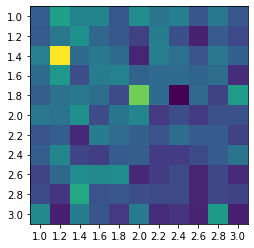

In [43]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_yticks(range(len(exposure_durations)))
ax.set_yticklabels(exposure_durations)
ax.set_xticks(range(len(times_until_symtoms)))
ax.set_xticklabels(times_until_symtoms);

In [63]:
step = 0.2
exposure_durations = np.arange(2, 3 + step, step)
times_until_symtoms = np.arange(2, 3 + step, step)
infection_durations = np.arange(8, 10 + step, step)

step = 0.25
exposure_duration_stds = np.arange(1.5, 2.4 + step, step)
times_until_symtoms_stds = np.arange(1.5, 2.4 + step, step)
infection_durations_stds = np.arange(3, 5 + step * 2, step * 2)

param_combinations = [(e, t, i, e_std, t_std, i_std) \
                                for e in exposure_durations \
                                for t in times_until_symtoms \
                                for i in infection_durations \
                                for e_std in exposure_duration_stds \
                                for t_std in times_until_symtoms_stds \
                                for i_std in infection_durations_stds]
print(f"{len(param_combinations)} parameter combinations")

67375 parameter combinations


Text(0.7162, 0.9, 'C')

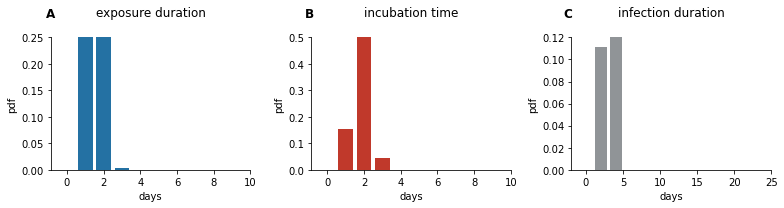

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
fig.subplots_adjust(wspace=0.3)
max_bins = [11, 11, 26]
steps = [1, 1, 2]
colors = ['#2471A3', '#C0392B', '#909497']
xticks = [range(0, 11, 2), range(0, 11, 2), range(0, 26, 5)]
labels = ['exposure duration\n', 'incubation time\n', 'infection duration\n']
ymaxes = [0.25, 0.5, 0.12]

for ax, max_bin, step, color, xtick, label, ymax, param in zip(axes, max_bins, steps, colors,\
    xticks, labels, ymaxes, [exposure_duration, time_until_symptoms, infection_duration]):
    ax.hist(param, bins=range(0, max_bin, step), rwidth=0.8, color=color,
            density=True, align='left')
    ax.set_xticks(xtick)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(label)
    ax.set_ylabel('pdf')
    ax.set_xlabel('days')
    ax.set_ylim(0, ymax)

fig.tight_layout()
fig.text(0.062, 0.9, 'A', fontsize=12, fontweight='bold')
fig.text(0.39, 0.9, 'B', fontsize=12, fontweight='bold')
fig.text(0.7162, 0.9, 'C', fontsize=12, fontweight='bold')